Check the running torch version

In [1]:
import torch
torch.__version__

'1.2.0'

In [2]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required

# Create a dataset for lines segmentation

Crop original forms images and contruct masks with the following labels: 0=background, 1=odd-numbered line, 2=even-numbered line

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import sys
sys.path.append('..')

import toml

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())  # Source: https://github.com/fastai/fastai/blob/master/fastai/core.py#L236

from tqdm import tqdm

from PIL import Image

In [4]:
from src.datasets import Dataset
from src.utils import img_to_array, array_to_img

In [5]:
lines_detector_path = Dataset.processed_data_path()/"lines-segmentation"
lines_detector_images_path = lines_detector_path/"images"
lines_detector_masks_path = lines_detector_path/"masks"

lines_detector_images_path.mkdir(parents=True, exist_ok=True)
lines_detector_masks_path.mkdir(parents=True, exist_ok=True)

In [6]:
cache_path = Dataset.cache_data_path()/"datasets"
data_path = cache_path/"iamdb"

In [7]:
import xml.etree.ElementTree as ElementTree
from typing import Dict, List

DOWNSAMPLE_FACTOR = 2  # If images were downsampled, the regions must also be.
LINE_REGION_PADDING = 0  # add this many pixels around the exact coordinates

def get_image_file_name_from_xml_file(filename: str) -> str:
    """Get the image file name."""
    xml_root_element = ElementTree.parse(filename).getroot()  # nosec
    return xml_root_element.attrib['id'] + ".jpg"

def get_line_strings_from_xml_file(filename: str) -> List[str]:
    """Get the text content of each line. Note that we replace &quot; with "."""
    xml_root_element = ElementTree.parse(filename).getroot()  # nosec
    xml_line_elements = xml_root_element.findall('handwritten-part/line')
    return [el.attrib['text'].replace('&quot;', '"') for el in xml_line_elements]

def get_line_regions_from_xml_file(filename: str) -> List[Dict[str, int]]:
    """Get the line region dict for each line."""
    xml_root_element = ElementTree.parse(filename).getroot()  # nosec
    xml_line_elements = xml_root_element.findall('handwritten-part/line')
    return [_get_line_region_from_xml_element(el) for el in xml_line_elements]


def _get_line_region_from_xml_element(xml_line) -> Dict[str, int]:
    """
    line (xml element): has x, y, width, and height attributes
    """
    word_elements = xml_line.findall('word/cmp')
    x1s = [int(el.attrib['x']) for el in word_elements]
    y1s = [int(el.attrib['y']) for el in word_elements]
    x2s = [int(el.attrib['x']) + int(el.attrib['width']) for el in word_elements]
    y2s = [int(el.attrib['y']) + int(el.attrib['height']) for el in word_elements]
    return {
        'x1': min(x1s) // DOWNSAMPLE_FACTOR - LINE_REGION_PADDING,
        'y1': min(y1s) // DOWNSAMPLE_FACTOR - LINE_REGION_PADDING,
        'x2': max(x2s) // DOWNSAMPLE_FACTOR + LINE_REGION_PADDING,
        'y2': max(y2s) // DOWNSAMPLE_FACTOR + LINE_REGION_PADDING
    }

In [8]:
xml_files = list((data_path / "xml").glob("*.xml"))
len(xml_files)

1539

In [9]:
index = 0
xml_file_name = xml_files[index]
xml_file_name

PosixPath('/home/jupyter/lines-segmentation-pytorch/data/cache/datasets/iamdb/xml/h07-007.xml')

## Build a dataset for training

### Crop images and save them for training

Also save seperate mask images where 0=background, 1=odd-numbered line, 2=even-numbered 

In [10]:
target_height_width = 256

buffer = 30

Check cropping on one image

Top 345, bottom 1251, left 135, right 1150; height 906, width 1015
Cropped image shape (906, 1015)


(['There is no reason to suppose that this pattern is peculiar to',
  'Crawley. The development corporations have aimed at a varied',
  'pattern of industry, offering a reasonable choice of',
  'employer as well as choice of occupation for men, women and',
  'school-leavers, with due regard to the industries',
  'already established in their towns. Inevitably engineering,',
  'including the motor vehicle and aircraft industries,',
  'predominates in all the London new towns since these are',
  'among the industries which have expanded most',
  'during the last ten years in the country generally.'],
 <matplotlib.image.AxesImage at 0x7f4fb1dd8550>)

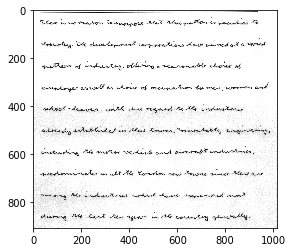

In [11]:
image = Image.open(data_path/"forms"/get_image_file_name_from_xml_file(xml_file_name))
regions = get_line_regions_from_xml_file(xml_file_name)
lines = get_line_strings_from_xml_file(xml_file_name)

left = min([region['x1'] for region in regions]) - buffer
right = max([region['x2'] for region in regions]) + buffer
top = min([region['y1'] for region in regions]) - buffer
bottom = max([region['y2'] for region in regions]) + buffer
print(f"Top {top}, bottom {bottom}, left {left}, right {right}; height {bottom - top}, width {right - left}")

cropped_image = img_to_array(image)[top:bottom, left:right]
print(f"Cropped image shape {cropped_image.shape}")
cropped_image = array_to_img(cropped_image)

lines, plt.imshow(cropped_image, cmap='gray')

Crop all available images

In [12]:
from typing import Tuple

def crop_and_resize(image: Image, crop_box: Tuple[int, int, int, int], target_height_width: int, fill_with_white: bool) -> Image:
    '''
    Return a square cropped image where crop_box is a 4-tuple defining the left, upper, right, and lower pixel 
    used to crop the original image.
    '''
    # Crop image
    cropped_image = image.crop(crop_box)
    cropped_image = img_to_array(cropped_image)
    
    # Square and resize it
    height, width = cropped_image.shape
    new_height_width = max(height, width)
    new_shape = (new_height_width, new_height_width)
    target_size = (target_height_width, target_height_width)
    
    # Start with a whie square image
    square_image = (255 if fill_with_white else 0) * np.ones(new_shape, dtype=np.uint8)
    
    margin_vertical = (new_height_width - height) // 2
    margin_horizontal = (new_height_width - width) // 2
    square_image[margin_vertical:height + margin_vertical, margin_horizontal:width + margin_horizontal] = cropped_image
    
    # Resize to traget final size and return to caller
    return array_to_img(square_image).resize(target_size)

In [13]:
def generate_lines_detector_dataset(xml_files, debug=False):
    if debug:
        xml_files = xml_files[:5]
    
    for xml_file in tqdm(xml_files):
        regions = get_line_regions_from_xml_file(xml_file)

        image_file_name = get_image_file_name_from_xml_file(xml_file)
        image = Image.open(data_path/"forms"/image_file_name)
        image_array = img_to_array(image)

        left = min([region['x1'] for region in regions]) - buffer
        right = max([region['x2'] for region in regions]) + buffer
        top = min([region['y1'] for region in regions]) - buffer
        bottom = max([region['y2'] for region in regions]) + buffer
        crop_box = (left, top, right, bottom)

        # Crop image
        cropped_image = crop_and_resize(image, crop_box, target_height_width, fill_with_white=True)
    
        # Deal with the masks
        mask_image = np.zeros(image.size, dtype=np.uint8)
        for index, line in enumerate(regions, 1):
            width = line['x2'] - line['x1']
            height = line['y2'] - line['y1']
            color = 255

            mask_image[line['y1']:line['y2'], line['x1']:line['x2'], ] = color

        mask_image = array_to_img(mask_image)
        mask_image = crop_and_resize(mask_image, crop_box, target_height_width, fill_with_white=False)

        # Debugging
        if debug:
            print(f"Top {top}, bottom {bottom}, left {left}, right {right}; height {bottom - top}, width {right - left}")
            print(f"Cropped image size {cropped_image.size}")
            print(f"Mask image size {mask_image.size}")
            
            plt.subplot(1, 2, 1)
            plt.imshow(cropped_image, cmap='gray')

            plt.subplot(1, 2, 2)
            plt.imshow(mask_image, cmap='gray')

            plt.show()
        else:
            # Save the final image
            cropped_image.save(lines_detector_images_path/f"{xml_file.stem}.png")

            # Save the mask image
            mask_image.save(lines_detector_masks_path/f"{xml_file.stem}.png")
            

generate_lines_detector_dataset(xml_files, debug=False)

100%|██████████| 1539/1539 [02:13<00:00, 11.51it/s]


## Split the data into train/valid/test

In [14]:
lines_detector_train_images_path = lines_detector_path/"train"/"images"
lines_detector_train_masks_path = lines_detector_path/"train"/"masks"

lines_detector_valid_images_path = lines_detector_path/"valid"/"images"
lines_detector_valid_masks_path = lines_detector_path/"valid"/"masks"

lines_detector_test_images_path = lines_detector_path/"test"/"images"
lines_detector_test_masks_path = lines_detector_path/"test"/"masks"

Get all available data

In [15]:
sorted_image_names = sorted(lines_detector_images_path.glob("*.png"))
sorted_mask_names = sorted(lines_detector_masks_path.glob("*.png"))

Define the splits

In [16]:
train_test_split = .2
train_valid_split = .2

total_length = len(sorted_image_names)
test_length = int(total_length * train_test_split)
valid_length = int((total_length - test_length) * train_test_split)
train_length = int(total_length - test_length - valid_length)

total_length, test_length, valid_length, train_length

(1539, 307, 246, 986)

In [17]:
train_x = sorted_image_names[:train_length]
train_y = sorted_mask_names[:train_length]

valid_x = sorted_image_names[train_length : train_length + valid_length]
valid_y = sorted_mask_names[train_length : train_length + valid_length]

test_x = sorted_image_names[train_length + valid_length:]
test_y = sorted_mask_names[train_length + valid_length:]

len(train_x), len(valid_x), len(test_x)

(986, 246, 307)

Remove old dirs

In [18]:
!rm -r {lines_detector_train_images_path}
!rm -r {lines_detector_train_masks_path}
!rm -r {lines_detector_valid_images_path}
!rm -r {lines_detector_valid_masks_path}
!rm -r {lines_detector_test_images_path}
!rm -r {lines_detector_test_masks_path}

lines_detector_train_images_path.mkdir(parents=True, exist_ok=True)
lines_detector_train_masks_path.mkdir(parents=True, exist_ok=True)
lines_detector_valid_images_path.mkdir(parents=True, exist_ok=True)
lines_detector_valid_masks_path.mkdir(parents=True, exist_ok=True)
lines_detector_test_images_path.mkdir(parents=True, exist_ok=True)
lines_detector_test_masks_path.mkdir(parents=True, exist_ok=True)

Copy files to new dirs

In [19]:
for image, mask in tqdm(zip(train_x, train_y)):
    !mv {image} {lines_detector_train_images_path}
    !mv {mask} {lines_detector_train_masks_path}

986it [03:35,  4.57it/s]


In [20]:
for image, mask in tqdm(zip(valid_x, valid_y)):
    !mv {image} {lines_detector_valid_images_path}
    !mv {mask} {lines_detector_valid_masks_path}

246it [00:54,  4.55it/s]


In [21]:
for image, mask in tqdm(zip(test_x, test_y)):
    !mv {image} {lines_detector_test_images_path}
    !mv {mask} {lines_detector_test_masks_path}

307it [01:07,  4.56it/s]
